In [1]:
import pygmt
import numpy as np
import xarray as xr
from scipy.interpolate import interpn

## Load a 3D velocity model

The velocity model of [FWEA18](http://ds.iris.edu/ds/products/emc-fwea18/) is selected for this example. A netcdf file can be downloaded [here](http://ds.iris.edu/files/products/emc/emc-files/FWEA18_kmps.nc). Now loading the `netcdf` file to `xr.DataArray`.

In [2]:
raw_data = xr.open_dataset('FWEA18_kmps.nc')
raw_data

<xarray.Dataset>
Dimensions:    (depth: 81, latitude: 201, longitude: 241)
Coordinates:
  * depth      (depth) float32 0.0 10.0 20.0 30.0 ... 770.0 780.0 790.0 800.0
  * latitude   (latitude) float32 10.0 10.25 10.5 10.75 ... 59.5 59.75 60.0
  * longitude  (longitude) float32 90.0 90.25 90.5 90.75 ... 149.5 149.8 150.0
Data variables:
    vpv        (depth, latitude, longitude) float32 ...
    vph        (depth, latitude, longitude) float32 ...
    vsv        (depth, latitude, longitude) float32 ...
    vsh        (depth, latitude, longitude) float32 ...
    eta        (depth, latitude, longitude) float32 ...
    qmu        (depth, latitude, longitude) float32 ...
    rho        (depth, latitude, longitude) float32 ...
Attributes: (12/32)
    title:                           Full Waveform inversion of East Asia upd...
    id:                              FWEA18
    summary:                         FWEA18 is a high resolution FWI model of...
    keywords:                        seismic, full waveform inverison, tomogr...
    Conventions:                     CF-1.0
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    ...                              ...
    author_email:                    taokai@cup.edu.cn
    author_institution:              The Unconventional Natural Gas Institute...
    author_url:                      
    repository_name:                 EMC
    repository_institution:          IRIS DMC
    repository_pid:                  doi:10.17611/DP/16590514

## Initial points of a section

`pygmt.project` provide a function to generate coordinates along a section with given start and end points.

In [3]:
lon1, lon2, lat1, lat2 = 111, 142, 39, 35
points = pygmt.project(center='111/39', endpoint='142/35', generate=20, unit=True )

### Plot the section on the map

In [4]:
grid_topo = pygmt.datasets.load_earth_relief(resolution="05m", region=[108, 150, 24, 53])

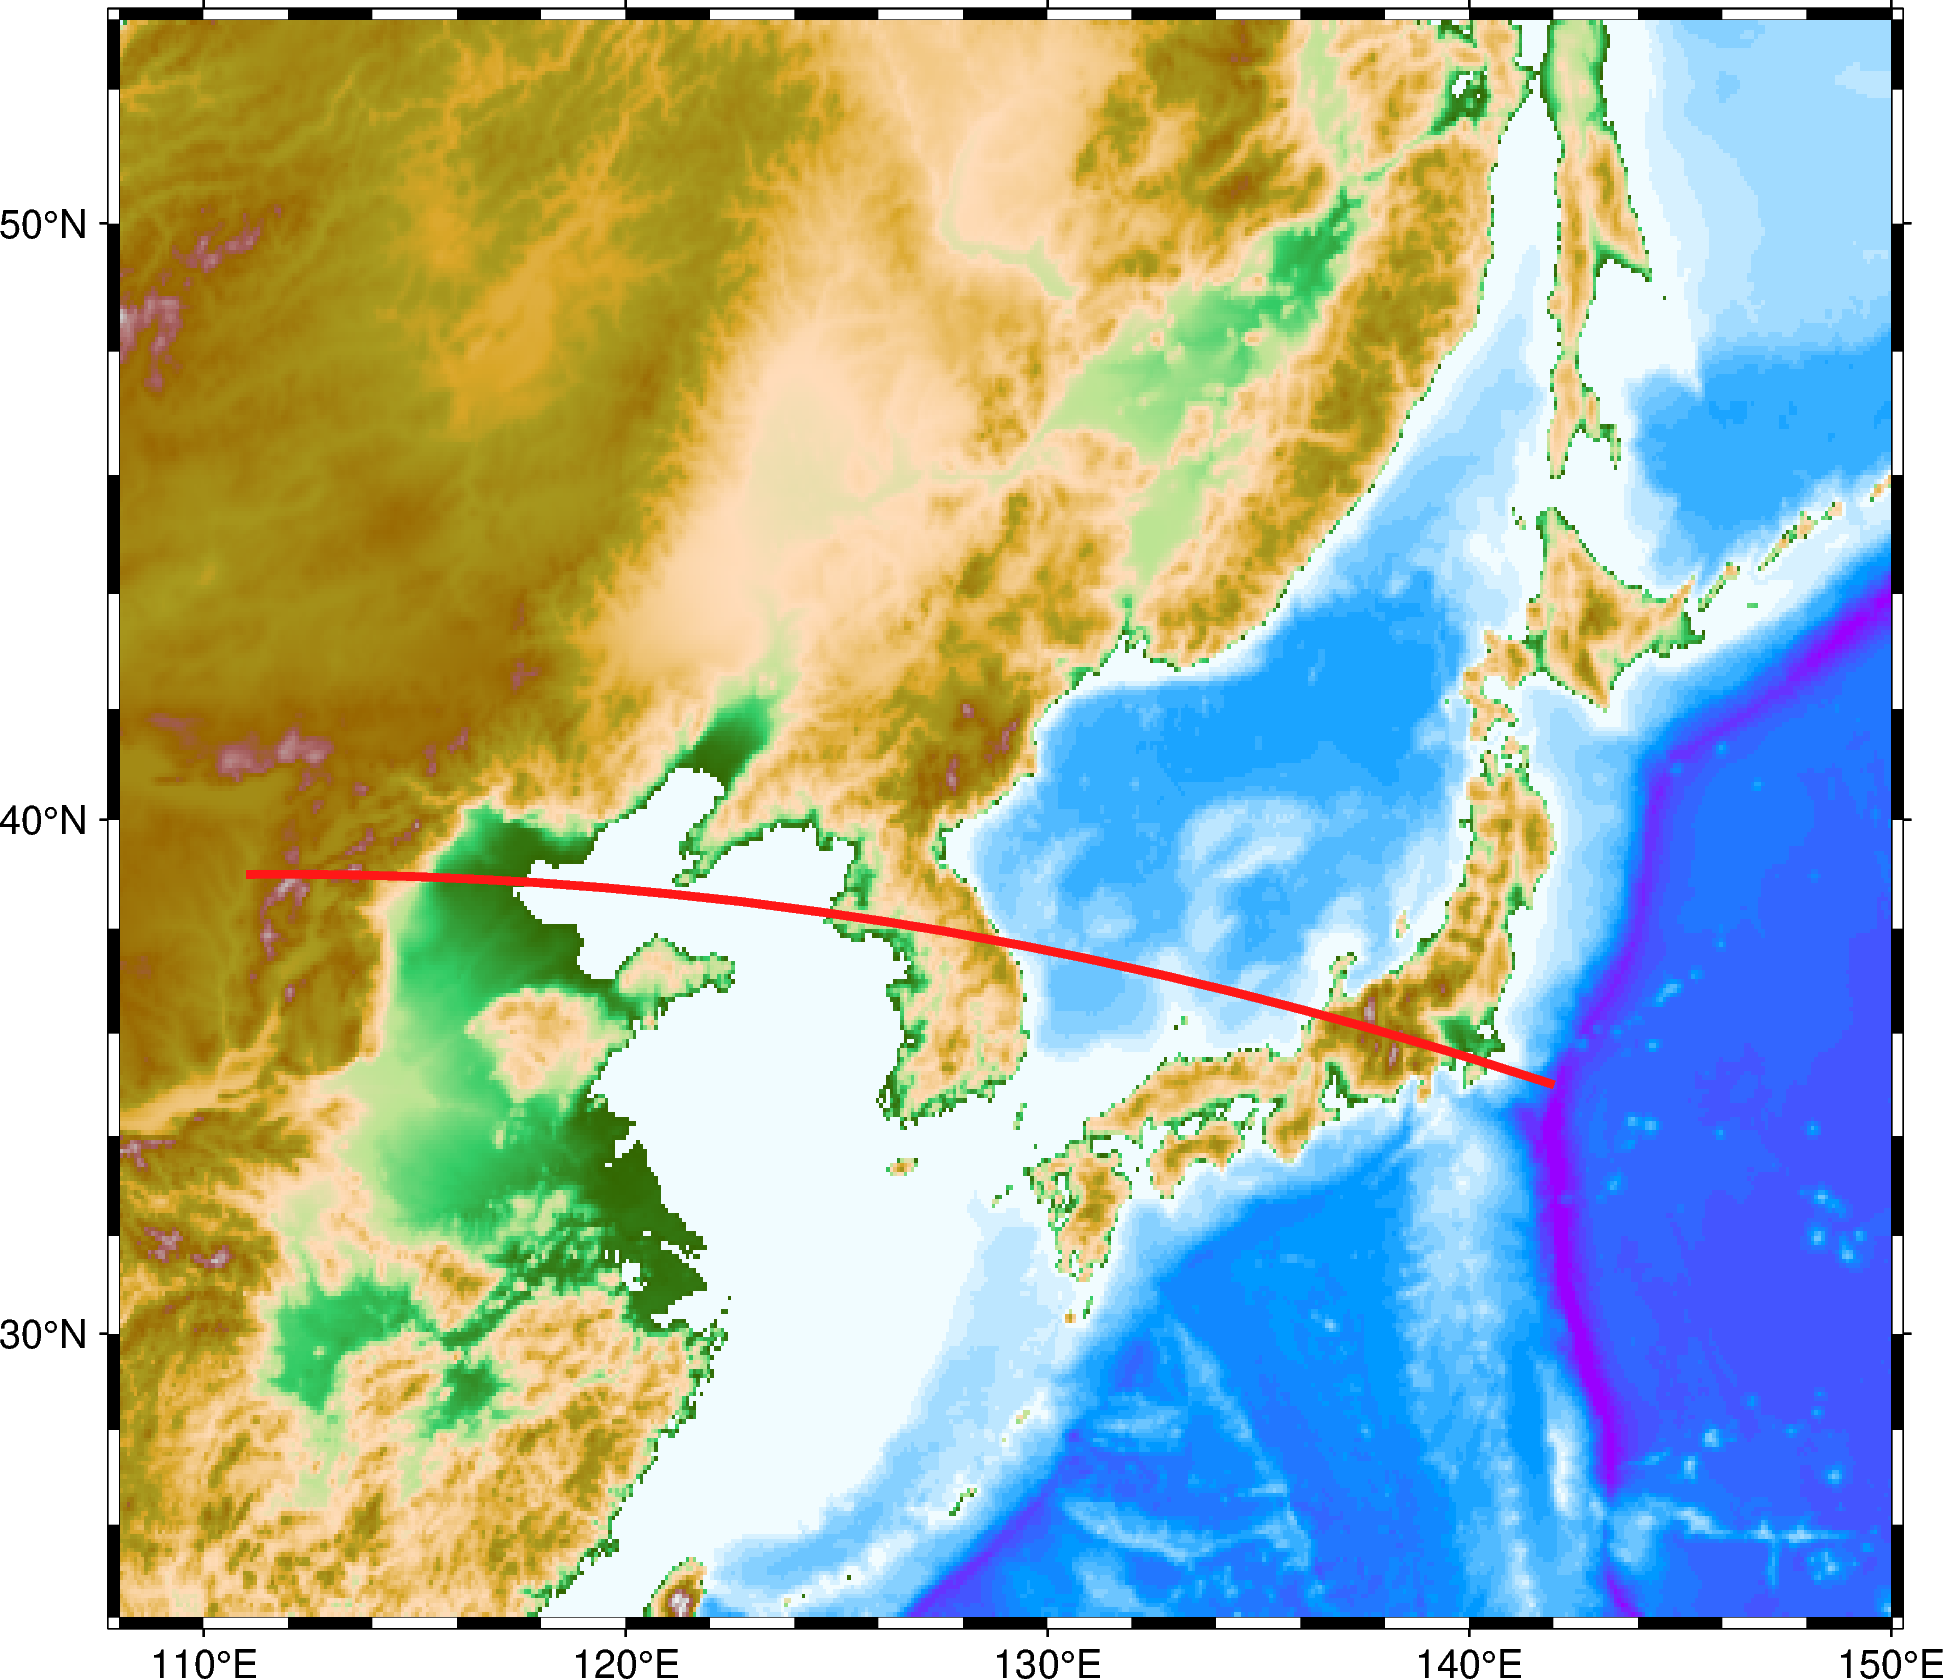

In [5]:
fig_map = pygmt.Figure()
fig_map.coast(
    region=[108, 150, 24, 53],
    projection="M15c",
    frame=True,
    borders=1,
    area_thresh=4000,
    shorelines="0.25p,black",
    land=255, water="skyblue"
)
fig_map.grdimage(grid=grid_topo, cmap='globe')
fig_map.plot(data=points.values[:, 0:2], pen='2p,255/23/23')
fig_map.show()

## Interpolate values using points along the section.

- Define depth series.
- Generate points.

In [6]:
depth = np.arange(0, 800+5, 5)
points2d = np.empty([0, 4])
for i, x in enumerate(points.values):
    for j,d in enumerate(depth):
        points2d = np.vstack((points2d, np.append(x, d)))

- Interpolation from `raw_data`
- Grids data using `pygmt.surface`

In [7]:
points_value = interpn((raw_data.depth.values, raw_data.latitude.values, raw_data.longitude.values),
                       raw_data.vpv.values, points2d[:, [3, 1, 0]])
grid = pygmt.surface(x=points2d[:, 0], y=points2d[:, 3], z=points_value,
              region=[lon1, lon2, depth[0], depth[-1]], spacing='0.2/2')

## Plot section with `grdimage`

In [46]:
fig_sec = pygmt.Figure()
fig_sec.basemap(frame=["WSne", 'xaf+l"Longitude (\\260)"', 'yaf+l"Depth (km)"'],
                region=[111, 142, 0, 800],
                projection='X15c/-8c')
pygmt.grd2cpt(grid, cmap='seis', continuous=True)
fig_sec.colorbar(position="JMR+o0.5c/0c+w7c/0.5c", frame=["xaf+l\"Vp (km/s)\""])
fig_sec.grdimage(grid, cmap=True)
fig_sec.shift_origin(yshift="8.25c")

In [47]:
ele = pygmt.grdtrack(points=points.values[:, 0:2], grid=grid_topo)
ele.values[:, 2] /= 1000

In [48]:
fig_sec.basemap(frame=['W', 'yaf+l"Elev. (km)"'],
                region=[lon1, lon2, -7, 3],
                projection='X15c/2c')
fig_sec.plot(x=ele.values[:, 0], y=ele.values[:, 2], pen='0.1p',
             close='+y0', color='gray')

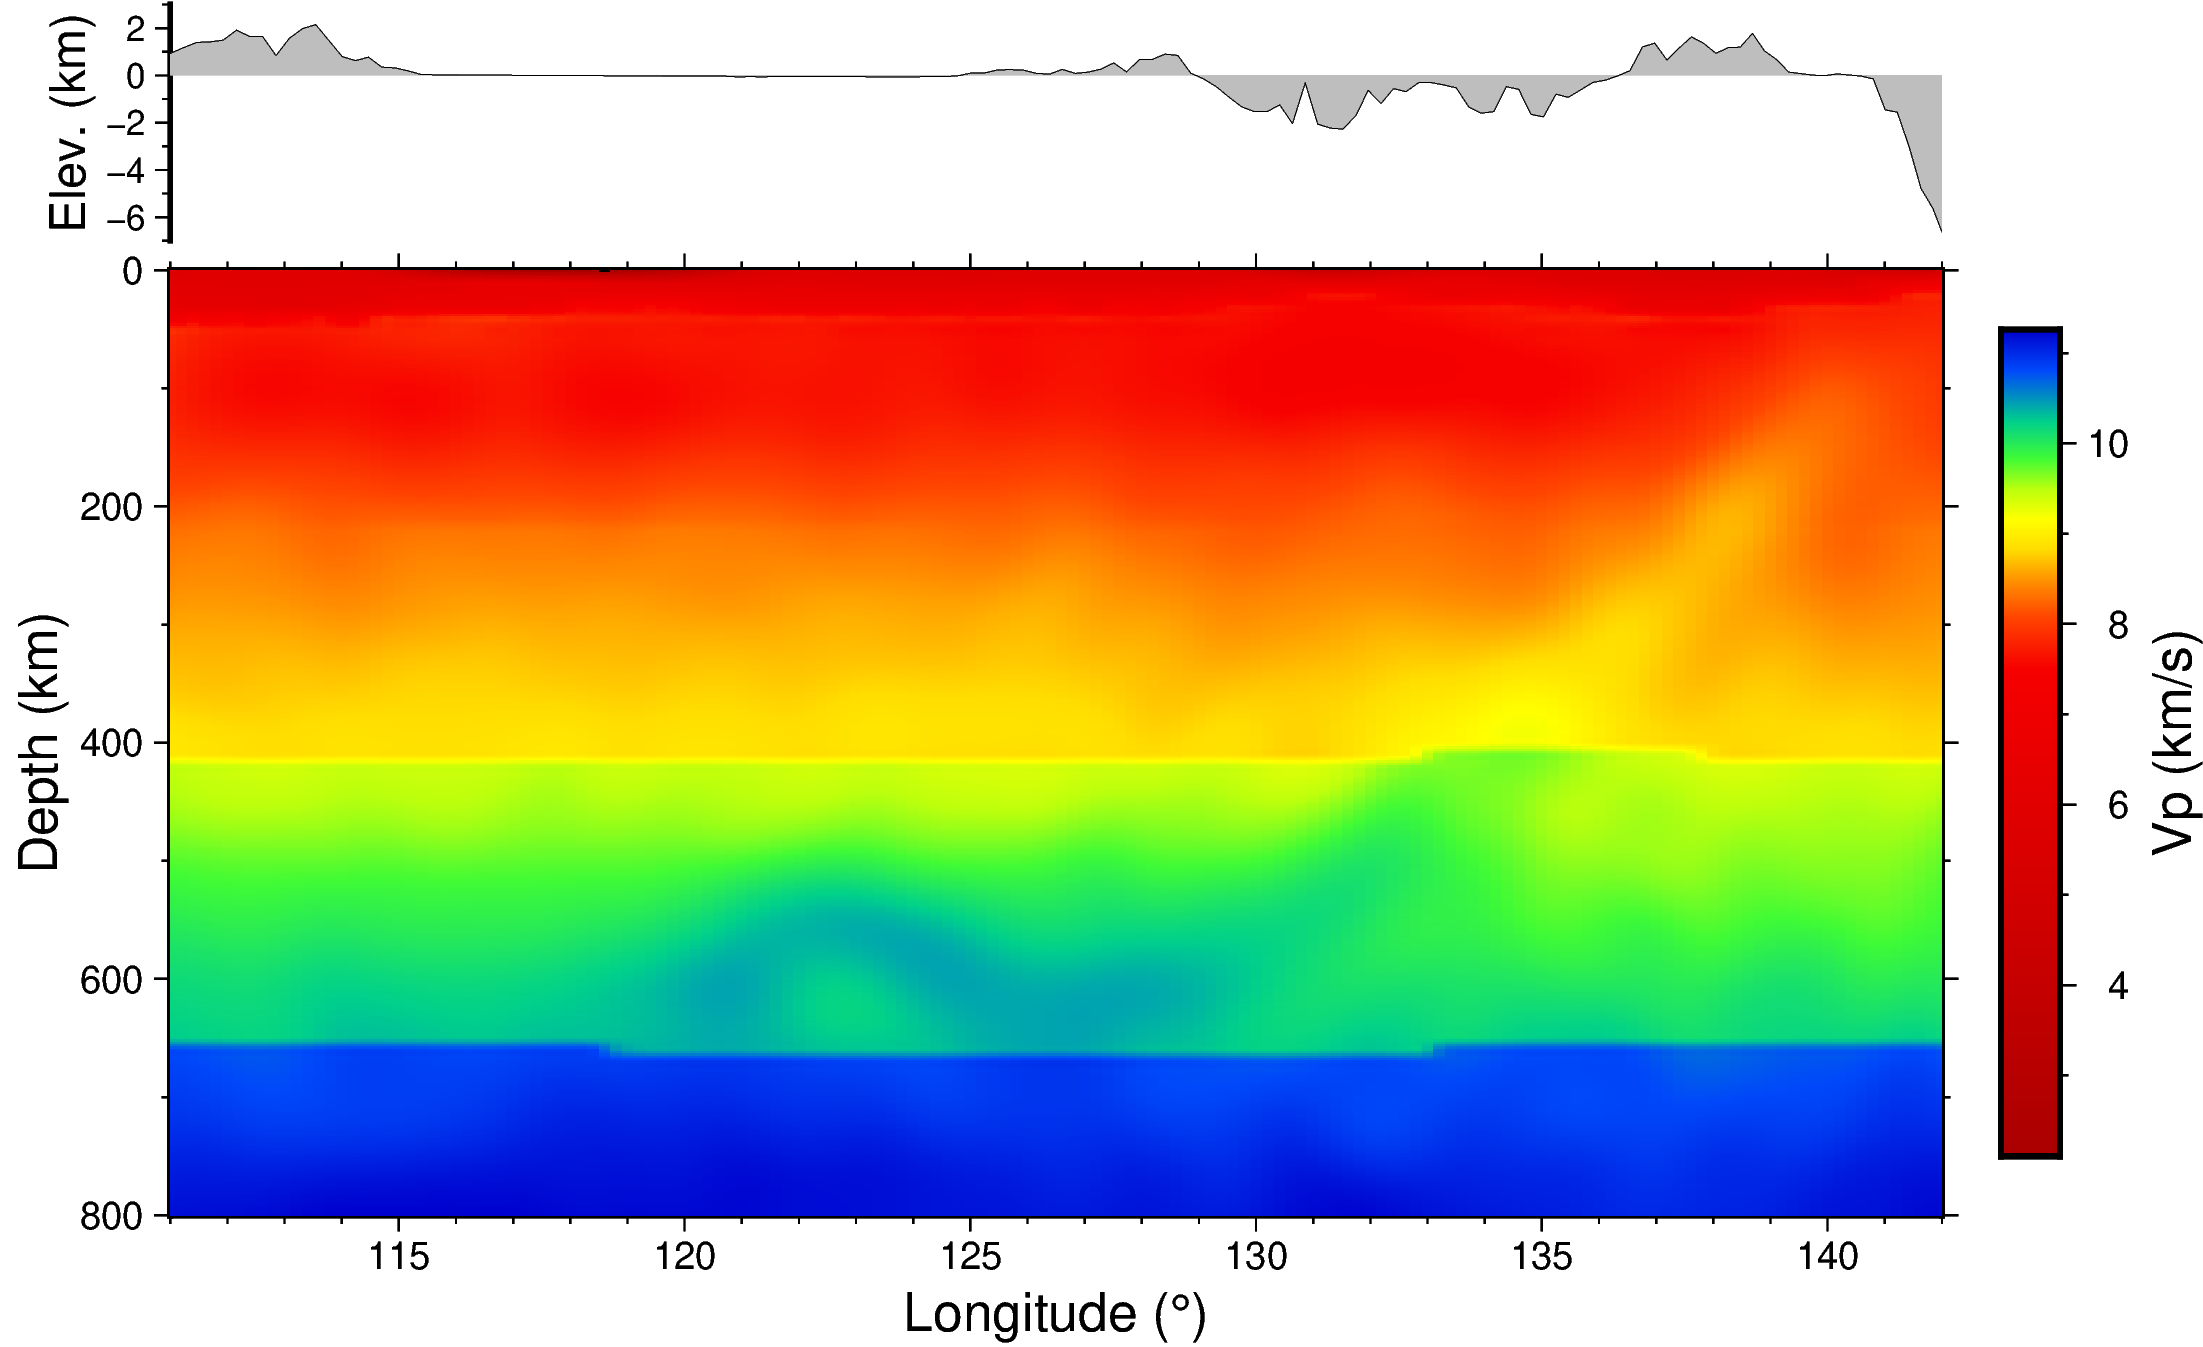

In [49]:
fig_sec.show()